# House Price prediction using machine learning
Predicting home prices can help determine the selling price of a home in a particular area and can help people find the right time to buy a house.

In this machine learning home price forecasting task, our task is to use data from the California Census to create a machine learning model to predict house prices in the state. The data includes features such as population, median income, and median home prices for each group aggregated in California.

Clusters are the smallest geographic unit with a population typically ranging from 600 to 3,000 people. We can call them districts for short. Ultimately, our machine learning model must learn from this data and be able to predict the average home price in any neighborhood, given all other metrics.g

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [23]:
df = pd.read_csv('housing.csv')

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [25]:
df['total_bedrooms'].isnull().sum()

207

In [26]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

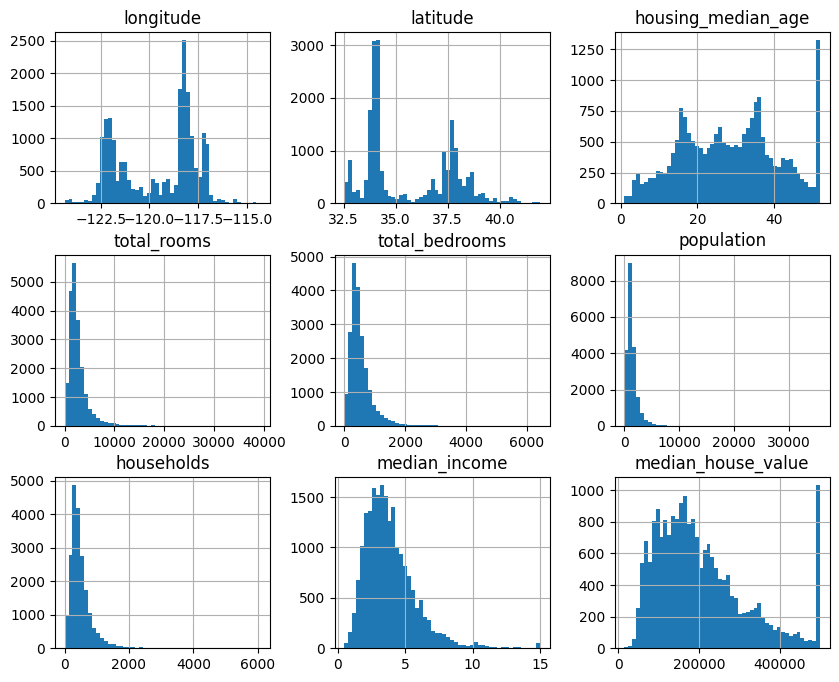

In [27]:
df.hist(bins=50, figsize=(10,8))
plt.show

In [28]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)


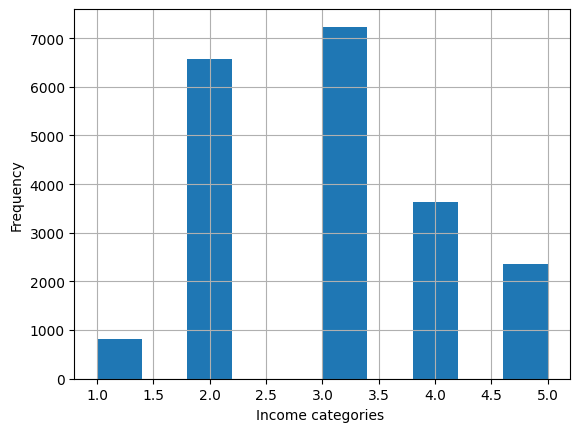

In [29]:
# The pd.cut() function is used to categorize the values in the 'median_income' column based on specified bin ranges.
df['income_cat'] = pd.cut(df['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

df['income_cat'].hist()
plt.xlabel('Income categories ')
plt.ylabel('Frequency')
plt.show()

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

print(strat_test_set['income_cat'].value_counts() / len(strat_test_set))

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64


In [33]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
    
df = strat_train_set.copy()


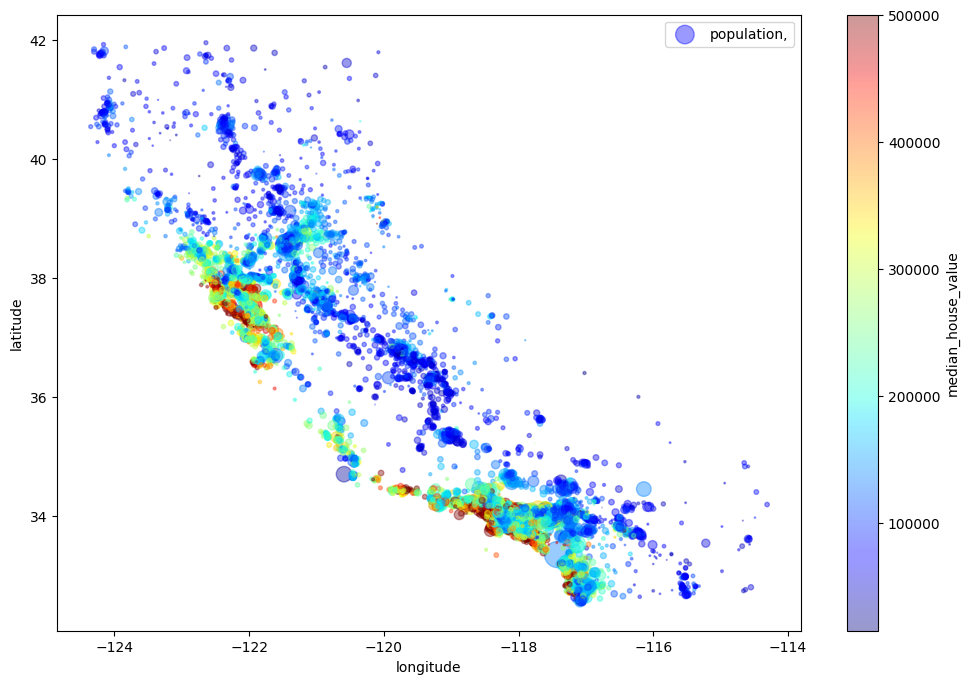

In [35]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,  s=df['population']/100, label='population,',
        figsize=(12, 8), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

plt.legend()
plt.show()

In [41]:
corr_matrix = df.drop(columns='ocean_proximity').corr()
print(corr_matrix['median_house_value'].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


In [43]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]

corr_matrix = df.drop(columns='ocean_proximity').corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

housing_prepared = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Define a pipeline for preprocessing
num_attribs = list(housing_prepared.select_dtypes(include=[np.number]).columns)
cat_attribs = list(housing_prepared.select_dtypes(include=[object]).columns)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),  # Use SimpleImputer to fill missing values with median
    ('scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

# Apply the full pipeline to housing_prepared
housing_prepared = full_pipeline.fit_transform(housing_prepared)

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(housing_prepared, housing_labels)

# Prepare new data for prediction
data = df.iloc[5:]
data_preparation = full_pipeline.transform(data)

# Make predictions
predictions = model.predict(data_preparation)
print("Predictions: ", predictions)

Predictions:  [208983.6813477  375046.02067267 270259.89859199 ... 221487.30785916
 241041.31494299 100662.66960931]
